# *Загрузка библиотек*

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from textwrap import wrap
import pickle
import torch
import torch.nn as nn
import re
import torch.nn.functional as F
import torch.utils.data as data
from torchvision.io import read_image
import textwrap
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import pickle
import torchtext
import random
import spacy

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

# **PyTorch**

Читаем данные из файла "captions.txt" и создаем датафрейм df

In [2]:
df = pd.read_csv("captions.txt", sep=',')
print("Суммарное количество подписей: {}".format(len(df)))
df

Суммарное количество подписей: 40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


Выводим изображения датасета на экран и соответствующие им подписи. \
Функция display_images принимает в качестве аргумента DataFrame temp_df, который содержит информацию об изображениях и их подписях.

Также, для каждого изображения выводится подпись (caption), которая была взята из столбца "caption" в DataFrame. Подпись разбивается на строки шириной 20 символов с помощью textwrap.wrap и выводится с помощью plt.title.


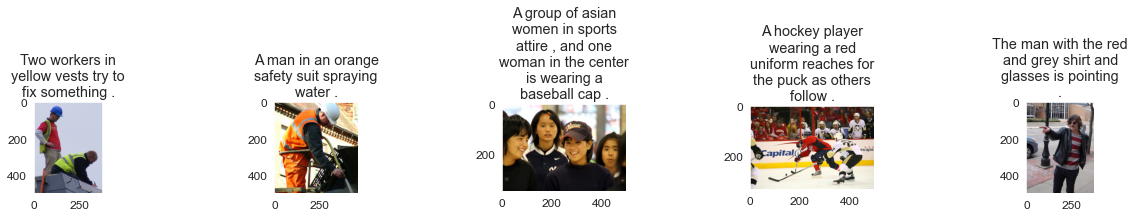

In [7]:
def display_images(temp_df):
    plt.figure(figsize = (20,15))
    for i in range(len(temp_df)):
        plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=1, wspace=1)
        image_path = f"C:\\Users\\Дарья\\Downloads\\archive\\Images\\{temp_df.image.iloc[i]}"
        image = read_image(image_path)
        plt.imshow(image.permute(1, 2, 0))
        caption = temp_df.caption.iloc[i]
        wrapped_caption = textwrap.wrap(caption, width=20)
        plt.title("\n".join(wrapped_caption))

display_images(df.sample(5))


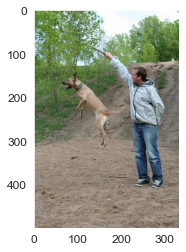

Подписи к фото: In this distorted photo a man is shown on a dirt path with a jumping dog .
Подписи к фото: a black dog jumping through some water
Подписи к фото: A black dog leaps out of the water .
Подписи к фото: a black dog runs through the water .
Подписи к фото: A black dog splashes in the water .


In [9]:
data_idx = random.randint(1,8000)
image_path = f"C:\\Users\\Дарья\\Downloads\\archive\\Images\\{df.image.iloc[data_idx]}"
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

for i in range(data_idx,data_idx+5):
    print("Подписи к фото:",df.iloc[i,1])

Загрузка модели VGG16 с предварительно обученными весами из библиотеки torchvision.
Затем создается новая модель model с помощью nn.Sequential, которая будет содержать только сверточные слои (без последнего полносвязного слоя) из предварительно обученной модели VGG16. "features.children()" позволяет получить доступ ко всем дочерним слоям модели VGG16, чтобы их использовать в качестве компонентов для создания новой модели или для выполнения других операций.

In [10]:
vgg16 = models.vgg16(pretrained=True)
model = nn.Sequential(*list(vgg16.features.children())[:-1])
print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Дарья/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|███████████████████████████████████████████████████████████████████████████████| 528M/528M [02:47<00:00, 3.30MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Извлечение признаков изображений с помощью предобученной модели model и сохраняем их в словаре features для дальнейшего использования.

In [13]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
features = {}
directory = os.path.join('C:/Users/Дарья/Downloads/archive/', 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = Image.open(img_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        feature = model(image).squeeze(0).cpu().numpy()
    image_id = img_name.split('.')[0]
    features[image_id] = feature

100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [57:30<00:00,  2.34it/s]


In [14]:
len(features)

8091

Сохраняем признаки изображени в файл pickle

In [15]:
pickle.dump(features, open(os.path.join('C:/Users/Дарья/Downloads/archive/', 'features.pkl'), 'wb'))

Считываем файл pickle с признаками изображений

In [16]:
with open(os.path.join('C:/Users/Дарья/Downloads/archive/', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Этот код читает файл с описаниями изображений и создает словарь, где каждому идентификатору изображения соответствует список описаний этого изображения.

In [17]:
with open(os.path.join('C:/Users/Дарья/Downloads/archive/', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()
    
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|████████████████████████████████████████████████████████████████████████| 40456/40456 [00:00<00:00, 404525.67it/s]


In [18]:
len(mapping)

8091

Этот код очищает описания в словаре mapping, приводя их к нижнему регистру, удаляя специальные символы, удаляя лишние пробелы и добавляя маркеры "startseq" и "endseq" в начало и конец описания соответственно.

In [19]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption
clean(mapping)

Данный код определяет класс ImageCaptionDataset, который представляет собой пользовательский датасет для работы с изображениями и описаниями. Затем создается экземпляр датасета dataset на основе переданных при инициализации признаков features и описаний captions.

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader

class ImageCaptionDataset(Dataset):
    def __init__(self, features, captions):
        self.features = features
        self.captions = captions
        
    def __getitem__(self, index):
        image_id = list(self.features.keys())[index]
        image_features = self.features[image_id]
        caption = self.captions[image_id]
        return image_features, caption
    
    def __len__(self):
        return len(self.features)
dataset = ImageCaptionDataset(features, mapping)

batch_size = 32
shuffle = True
num_workers = 4

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

Данный код создает список all_captions, который содержит все описания изображений из словаря mapping.

In [21]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

40455

Здесь, с помощью NLTK, мы токенизируем все описания изображений 

In [22]:
import nltk
from nltk.tokenize import word_tokenize
all_captions_text = ' '.join(all_captions)
tokens = word_tokenize(all_captions_text)
vocab_size = len(set(tokens)) + 1

Данный код содержит реализацию модели для генерации текстовых подписей к изображениям.

В начале кода загружается предварительно обученная сверточная модель ResNet-50 с помощью models.resnet50(pretrained=True). Затем последний слой модели удаляется, чтобы получить сверточные признаки изображений.

Затем определяется класс CaptionGenerator, который наследуется от nn.Module и содержит в себе определение архитектуры рекуррентной модели для генерации текста. В конструкторе класса инициализируются слои модели, включая вложение (nn.Embedding), LSTM (nn.LSTM) и полносвязный слой (nn.Linear).

Затем создается экземпляр модели model с заданными размерами вложений, скрытого состояния и размера словаря.

Определяются функция потерь (nn.CrossEntropyLoss) и оптимизатор (torch.optim.Adam).

После этого следует цикл обучения, где происходит проход по эпохам и батчам данных из загрузчика (dataloader). В каждой итерации происходит передача изображений через сверточную модель, прямой проход через рекуррентную модель, вычисление функции потерь, обратное распространение и обновление параметров модели.

После завершения обучения представлен пример использования модели. Загружается изображение с помощью функции load_image, а затем вызывается функция generate_caption, которая принимает изображение и генерирует текстовую подпись к нему. Результат выводится на экран.






In [23]:
def generate_caption(image):
    features = cnn(image.unsqueeze(0))
    generated_caption = []
    hidden = None

    for _ in range(max_length):
        inputs = model.embedding(torch.tensor([vocab.word2idx('<start>')])).unsqueeze(0)
        if hidden is not None:
            lstm_outputs, hidden = model.lstm(inputs, hidden)
        else:
            lstm_outputs, hidden = model.lstm(inputs)

        outputs = model.fc(lstm_outputs.squeeze(0))
        _, predicted = outputs.max(1)
        word = vocab.idx2word(predicted.item())
        generated_caption.append(word)

        if word == '<end>':
            break

    generated_sentence = ' '.join(generated_caption)

    return generated_sentence

In [24]:
import time
start_time= time.time()
cnn = models.resnet50(pretrained=True)
modules = list(cnn.children())[:-1]
cnn = nn.Sequential(*modules)
for param in cnn.parameters():
    param.requires_grad = False


class CaptionGenerator(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size):
        super(CaptionGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        captions = captions[:, :-1]
        embeddings = self.embedding(captions)
        inputs = torch.cat((features.unsqueeze(1), embeddings), 1)
        lstm_outputs, _ = self.lstm(inputs)
        outputs = self.fc(lstm_outputs)
        return outputs


embedding_size = 256
hidden_size = 512
vocab_size = vocab_size 
model = CaptionGenerator(embedding_size, hidden_size, vocab_size)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_threshold = 10000

num_epochs = 10

for epoch in range(num_epochs):
    if start_time > 100:
            print('Превышено время работы алгоритма')
            break
    for images, captions in dataloader:
        if start_time > 1000:
            print('Превышено время работы алгоритма')
            break
        features = cnn(images)
        
        outputs = model(features, captions)
        targets = captions[:, 1:].contiguous().view(-1)
        loss = criterion(outputs.view(-1, vocab_size), targets)
        if loss < loss_threshold: #порогове значение функции потерь 
            print('Остановка обучения')
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')


image = '997722733_0cb5439472.jpg'
print(caption)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Дарья/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:30<00:00, 3.40MB/s]


Превышено время работы алгоритма
startseq rock climber practices on rock climbing wall endseq


В ходе исследования, были выявленны бесконечные зависания алгоритма работы Pytorch для мультимодальных данных и соответствующих алгоритмов их анализа.

Одна из возможных причин может быть связана с различным управлением памятью и оптимизацией графов вычислений. TensorFlow, например, использует статический граф вычислений, который может быть оптимизирован и выполнен эффективно. PyTorch, с другой стороны, использует динамический граф вычислений, который предоставляет большую гибкость, но может потреблять больше ресурсов. На примере мультимодальных данных, потребовалось значительное количество ресурсов, а в следствии, и времени, что ни привело к эффективному результату. Следстиек

Так как текущая модель довольно сложна, это скорее всего приводит к проблемам с использованиями памяти и производительности. В таких случаях рекомендуется использовать оптимизации, такие как батчинг данных, уменьшение размерности модели, использование оптимизаторов с низкой памятью (например, LAMB или Adafactor) и другие методы, чтобы уменьшить потребление памяти и повысить производительность. Тем не менее, это не особо помогло, поэтому попробуем достичь поставленной задачи при помощи `TensorFlow`.

# **TensorFlow**

Путь к изображениям

In [25]:
image_path = 'C:/Users/Дарья/Downloads/archive/Images'

Считываем описания к изображениям и названия изображений

In [26]:
data = pd.read_csv("C:/Users/Дарья/Downloads/archive/captions.txt")
print("Суммарное количество подписей: {}".format(len(data)))
data.head()

Суммарное количество подписей: 40455


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [31]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(5):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/Users/Дарья/Downloads/archive/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

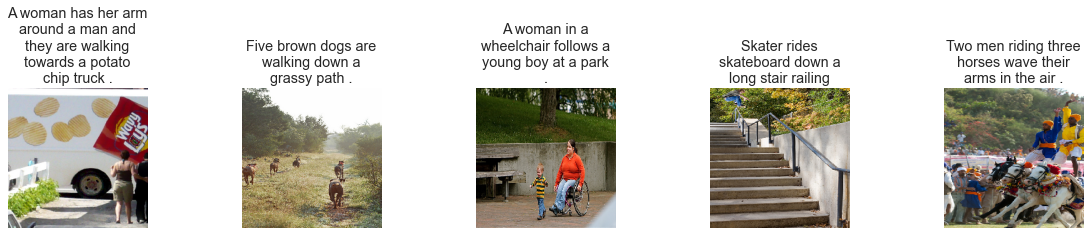

In [32]:
display_images(data.sample(5))

Создаём функцию предобработки описаний текста

In [33]:
captions = data['caption'].tolist()
captions[:10]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .',
 'A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [34]:
def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower()
    data['caption'] = data['caption'].apply(lambda x: re.sub("[^A-Za-z\s]", "", x))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 0]))
    data['caption'] = "startseq " + data['caption'] + " endseq"
    return data

Вызываем функцию text_preprocessing и переводим результат в список

In [35]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

Обучаем наш токенизатор на предобработанных подписях, определяем размер словаря (vocab_size) на основе словаря токенов, а также находим максимальную длину подписи (max_length). Затем происходит разделение списка изображений на обучающую и тестовую выборки.

Далее, объекты `train` и `test` представляют собой фильтрованные данные на основе списков train_images и val_images. С помощью reset_index(inplace=True, drop=True), индексы в этих объектах сбрасываются для последовательного нумерования без пропусков.

Наконец, tokenizer.texts_to_sequences([captions[1]])[0] преобразует вторую предобработанную подпись в список индексов токенов. Это позволяет представить текст в виде последовательности числовых индексов, соответствующих токенам.

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[2, 1, 19, 314, 64, 1, 194, 117, 3]

Здесь выполняется извлечение признаков из изображений с помощью модели DenseNet201 и сохраняет эти признаки в словаре для дальнейшего использования в модели генерации подписей к изображениям.






In [37]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = tf.expand_dims(img, axis=0)
    
    with tf.device('/gpu:0'):
        feature = fe.predict(img, verbose=0)
    
    features[image] = feature

82524592/82524592 [==============================] - 12s 0us/step


100%|████████████████████████████████████████████████████████████████████████████| 8091/8091 [1:10:29<00:00,  1.91it/s]


In [38]:
pickle.dump(features, open(os.path.join('C:/Users/Дарья/Downloads/archive/Images/', 'features.pkl'), 'wb'))

In [39]:
with open(os.path.join('C:/Users/Дарья/Downloads/archive/Images/', 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [40]:
features

{'1000268201_693b08cb0e.jpg': array([[7.8688572e-05, 7.3527923e-04, 1.1396131e-03, ..., 5.6516337e-01,
         2.2899958e-01, 6.9634604e-01]], dtype=float32),
 '1001773457_577c3a7d70.jpg': array([[1.2493510e-04, 4.5205440e-04, 1.9292686e-03, ..., 7.4854285e-02,
         2.0473561e+00, 9.0310819e-02]], dtype=float32),
 '1002674143_1b742ab4b8.jpg': array([[5.0413517e-05, 3.7104051e-04, 1.9412123e-03, ..., 8.7599248e-02,
         4.6895176e-01, 3.1748122e-01]], dtype=float32),
 '1003163366_44323f5815.jpg': array([[1.4095506e-04, 7.7881722e-04, 1.2702140e-03, ..., 2.2358407e-01,
         8.1239372e-02, 1.3333294e-01]], dtype=float32),
 '1007129816_e794419615.jpg': array([[9.8224293e-05, 7.2486617e-04, 1.8896527e-03, ..., 1.9271138e+00,
         1.3698289e+00, 1.7164357e-01]], dtype=float32),
 '1007320043_627395c3d8.jpg': array([[1.3486770e-04, 3.0724678e-04, 9.5219491e-04, ..., 2.6255938e-01,
         2.8396076e-02, 1.3737242e+00]], dtype=float32),
 '1009434119_febe49276a.jpg': array([[1.

Класс CustomDataGenerator предоставляет функциональность для генерации пакетов данных, которые могут быть использованы при обучении модели. Каждый пакет содержит изображения, входные последовательности текста и соответствующие целевые последовательности. Это позволяет эффективно использовать данные в процессе обучения модели.

In [41]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

Данный код определяет модель генерации подписей для изображений. Входы модели представлены двумя частями: input1 для признаков изображения и input2 для входных последовательностей текста.

Процесс моделирования начинается с обработки признаков изображения. Вход input1 проходит через полносвязный слой с активацией ReLU, что приводит к сжатым признакам изображения img_features.

Затем признаки изображения img_features преобразуются с помощью слоя Reshape для получения трехмерной формы (1, 32), необходимой для объединения с признаками текста.

Входные последовательности текста input2 проходят через слой Embedding, который выполняет векторное представление слов с помощью внутренних весов. Размерность векторов слов установлена равной 32.

Далее выполняется объединение признаков изображения и признаков текста с помощью слоя concatenate. Аргумент axis=1 указывает на объединение вдоль оси времени, чтобы каждый шаг времени соответствовал одному слову.

Следующим шагом является применение слоя LSTM к объединенным признакам. Этот слой обрабатывает последовательность входных данных и выдает выходные данные sentence_features.

Затем применяется слой Dropout с коэффициентом отсева 0.5 для предотвращения переобучения модели. Далее выполняется объединение x выходных признаков с признаками изображения img_features с помощью слоя add.

Следующие два слоя Dense выполняют дополнительные преобразования признаков для улучшения предсказаний модели.

Затем применяется слой Dropout с коэффициентом отсева 0.5, а затем последний слой Dense с функцией активации softmax для получения вероятностного распределения над всеми возможными словами.

Модель определена с использованием функционального API в Keras. Затем модель компилируется с функцией потерь categorical_crossentropy и оптимизатором Adam

Итоговая модель caption_model.summary() описывается в сводке модели, которая показывает архитектуру модели и общее количество параметров.

In [42]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [43]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 37)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

Данный код создает экземпляры генераторов данных для обучения (train_generator) и валидации (validation_generator).

In [44]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

ModelCheckpoint - сохраняет модель с лучшим значением функции потерь на валидационном наборе данных.

EarlyStopping - прекращает обучение, если функция потерь на валидационном наборе данных перестает улучшаться в течение определенного количества эпох. 

ReduceLROnPlateau - уменьшает скорость обучения (learning rate), если функция потерь на валидационном наборе данных перестает улучшаться в течение определенного количества эпох.

In [45]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

Этот код выполняет обучение модели caption_model на 10 эпохах. Во время выполнения будет выводится информация о функциях потерь на трейновой и валидационной выборках.

In [46]:
history = caption_model.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, learning_rate_reduction])

Epoch 1/10
537/537 [==============================] - ETA: 0s - loss: 4.6902
Epoch 1: val_loss improved from inf to 3.78934, saving model to model.h5
537/537 [==============================] - 5479s 10s/step - loss: 4.6902 - val_loss: 3.7893 - lr: 0.0010
Epoch 2/10
537/537 [==============================] - ETA: 0s - loss: 3.7781
Epoch 2: val_loss improved from 3.78934 to 3.51249, saving model to model.h5
537/537 [==============================] - 1321s 2s/step - loss: 3.7781 - val_loss: 3.5125 - lr: 0.0010
Epoch 3/10
537/537 [==============================] - ETA: 0s - loss: 3.5439
Epoch 3: val_loss improved from 3.51249 to 3.38223, saving model to model.h5
537/537 [==============================] - 1819s 3s/step - loss: 3.5439 - val_loss: 3.3822 - lr: 0.0010
Epoch 4/10
537/537 [==============================] - ETA: 0s - loss: 3.3954
Epoch 4: val_loss improved from 3.38223 to 3.31990, saving model to model.h5
537/537 [==============================] - 1434s 3s/step - loss: 3.3954 - v

Строим график функций потерь для трейновой и валидационной выборок

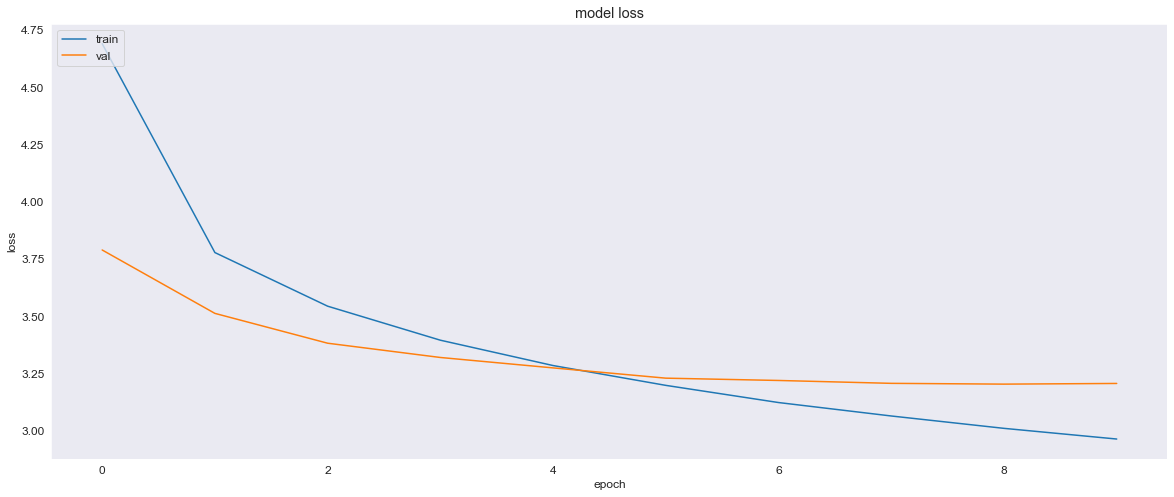

In [47]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Этот код представляет функцию idx_to_word, которая преобразует целочисленное значение обратно в соответствующее слово с помощью словаря tokenizer.word_index

In [48]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

Эта функция генерирует подпись для заданного изображения

In [49]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = caption_model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

Данный код выполняет выборку случайных примеров (samples) из набора данных test. Затем индексы в выборке сбрасываются и переиндексируются с помощью метода reset_index()

In [56]:
samples = test.sample(10)
samples.reset_index(drop=True,inplace=True)

После выполнения этого кода в столбце 'caption' каждой записи выборки samples будет содержаться предсказанная подпись для соответствующего изображения.

In [57]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 28ms/step


Выводим получившийся результат

In [58]:
def display_images(temp_df):
    num_images = len(temp_df) 
    fig = plt.figure(figsize=(18, 18)) 
    for i in range(num_images):
        plt.subplot(5, 5, i+1)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        image = readImage(f"C:/Users/Дарья/Downloads/archive/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))


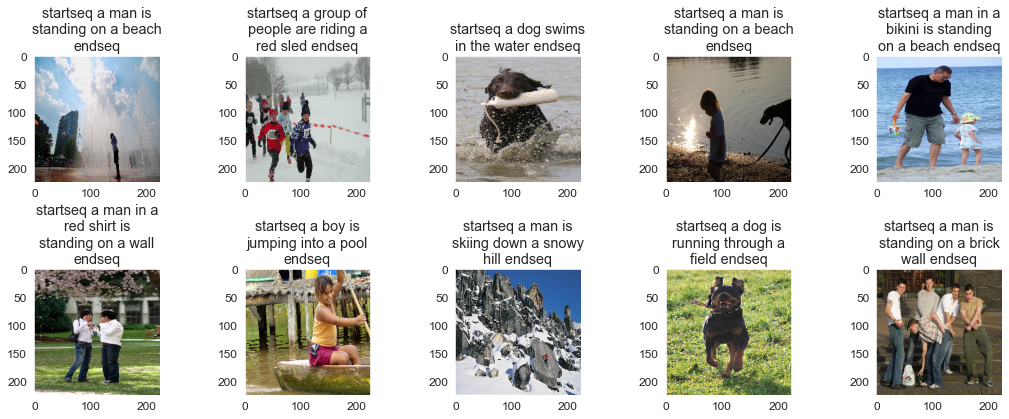

In [59]:
display_images(samples)

В целом описания получились достаточно правдоподобными. Результат можно улучшить, изменив гиперпараметры и усложнив модель, увеличивая количество слоёв или нейронов, но это может потребовать большей вычислительной мощности.